# Latent semantic analysis, no tears

[Latent semantic analysis](https://en.wikipedia.org/wiki/Latent_semantic_analysis) (LSA) is a natural language processing (NLP) technique to bridge terms and documents through concepts. The idea is that there are hidden concepts (latent concepts) through which words and documents are related. The heart and soul of LSA is the application of [singular value decomposition](https://en.wikipedia.org/wiki/Singular-value_decomposition) (SVD) to a term-document matrix. In this tutorial, we will see how SVD is applied to documents and terms in those documents to flush out the latent concepts. 

In [1]:
import pandas as pd
import numpy as np

df = pd.DataFrame(
    data={
        'd1': [1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0],
        'd2': [1, 1, 0, 1, 0, 0, 1, 1, 0, 2, 1],
        'd3': [1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1]
    }, 
    index=['a', 'arrived', 'damaged', 'delivery', 'fire', 'gold', 'in', 'of', 'shipment', 'silver', 'truck'])

A = df.as_matrix()
q = np.array([0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1]).reshape(-1, 1)

print('data shape is {}'.format(A.shape))
print('q shape is {}'.format(q.shape))

data shape is (11L, 3L)
q shape is (11L, 1L)


In [2]:
df = pd.DataFrame(
    data={
        'd1': [0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0],
        'd2': [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0],
        'd3': [1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0],
        'd4': [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
        'd5': [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
        'd6': [0, 1, 0, 0, 1, 1, 0, 0, 2, 0, 0],
        'd7': [0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0],
        'd8': [0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0],
        'd9': [0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0]
    }, 
    index=['book', 'dads', 'dummies', 'estate', 'guide', 'investing', 'market', 'real', 'rich', 'stock', 'value'])

A = df.as_matrix()
q = np.array([0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0]).reshape(-1, 1)

print('data shape is {}'.format(A.shape))
print('q shape is {}'.format(q.shape))

data shape is (11L, 9L)
q shape is (11L, 1L)


In [3]:
from numpy.linalg import svd

U, S, VT = svd(A, full_matrices=False)
S = np.diag(S)
V = VT.transpose()

In [4]:
U

array([[-0.15283556,  0.26603445, -0.04450319,  0.358775  , -0.34803847,
         0.63535811,  0.31922832, -0.32449103, -0.20773802],
       [-0.23746367, -0.37826282,  0.08595889,  0.01499714, -0.02516682,
         0.22127486, -0.29223307,  0.36798708, -0.60717185],
       [-0.13026538,  0.17428415, -0.06901432, -0.18290664,  0.74967516,
         0.22463392,  0.18161361,  0.04150121, -0.33676831],
       [-0.18440432, -0.1939483 , -0.44568964, -0.32244773, -0.2327524 ,
        -0.04718926,  0.00176424, -0.14417187, -0.10058143],
       [-0.2161232 , -0.08727248,  0.46011902, -0.0203134 , -0.06163386,
        -0.52298039,  0.33344464, -0.42676947, -0.40364266],
       [-0.74009654,  0.21114703, -0.21075317,  0.09834346,  0.17016449,
        -0.16705767,  0.17823168,  0.12803352,  0.30776   ],
       [-0.17687585,  0.29791161,  0.28320277, -0.19824148, -0.41126217,
        -0.0419337 ,  0.18342887,  0.63298255, -0.03749517],
       [-0.18440432, -0.1939483 , -0.44568964, -0.32244773, -0

In [5]:
S

array([[3.90941804, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 2.60911881, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 1.99682784, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 1.68702498, 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 1.54678536,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        1.04451835, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.59375541, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.41040138, 0.        ],


In [6]:
V

array([[-0.35383506,  0.32093722,  0.40910955, -0.27957328, -0.22548656,
        -0.57638477,  0.06642748,  0.00528064, -0.37251056],
       [-0.22263209,  0.14772466, -0.14010597, -0.05012563,  0.59467827,
         0.05512229,  0.6060497 ,  0.41309491, -0.10883818],
       [-0.33764656,  0.45634958,  0.15639762, -0.05486505, -0.41064775,
         0.53258425,  0.04248441,  0.25449627,  0.36251709],
       [-0.25985153,  0.23776591, -0.24526283,  0.66012743, -0.12769307,
         0.13105895,  0.14705913, -0.38766784, -0.41788486],
       [-0.22075733,  0.13580258, -0.22297589,  0.44746016,  0.09731454,
        -0.4772196 , -0.39058366,  0.40299965,  0.36154119],
       [-0.49108087, -0.54864149,  0.50966892,  0.24530407,  0.13015221,
         0.03012216,  0.13155708, -0.18042741,  0.26492893],
       [-0.28364968, -0.06774301, -0.55194165, -0.32397387, -0.19093813,
        -0.25029354,  0.30611957, -0.39061815,  0.39994891],
       [-0.28662975,  0.3070034 ,  0.00229626, -0.25844245,  0

In [7]:
VT

array([[-0.35383506, -0.22263209, -0.33764656, -0.25985153, -0.22075733,
        -0.49108087, -0.28364968, -0.28662975, -0.43726389],
       [ 0.32093722,  0.14772466,  0.45634958,  0.23776591,  0.13580258,
        -0.54864149, -0.06774301,  0.3070034 , -0.43829115],
       [ 0.40910955, -0.14010597,  0.15639762, -0.24526283, -0.22297589,
         0.50966892, -0.55194165,  0.00229626, -0.33802383],
       [-0.27957328, -0.05012563, -0.05486505,  0.66012743,  0.44746016,
         0.24530407, -0.32397387, -0.25844245, -0.22000351],
       [-0.22548656,  0.59467827, -0.41064775, -0.12769307,  0.09731454,
         0.13015221, -0.19093813,  0.5649083 , -0.16907987],
       [-0.57638477,  0.05512229,  0.53258425,  0.13105895, -0.4772196 ,
         0.03012216, -0.25029354,  0.17951196,  0.20100349],
       [ 0.06642748,  0.6060497 ,  0.04248441,  0.14705913, -0.39058366,
         0.13155708,  0.30611957, -0.49821564, -0.30507205],
       [ 0.00528064,  0.41309491,  0.25449627, -0.38766784,  0

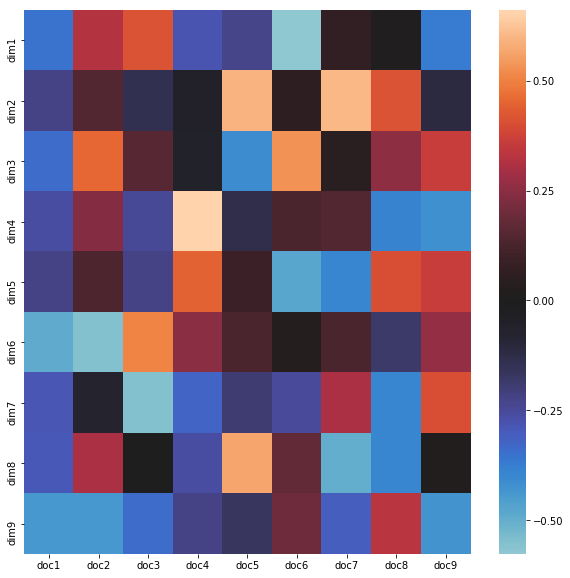

In [8]:
%matplotlib inline

import matplotlib.pylab as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 10))
x_labels = ['doc{}'.format(i+1) for i in range(V.shape[0])]
y_labels = ['dim{}'.format(i+1) for i in range(V.shape[1])]
sns.heatmap(V, xticklabels=x_labels, yticklabels=y_labels, center=0.0, ax=ax)
plt.show()

In [9]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=min(4, VT.shape[0])).fit(VT)
print(kmeans.labels_)
print(kmeans.cluster_centers_)

[1 1 0 0 3 2 1 1 1]
[[ 0.06476813 -0.0951158   0.05076629  0.2074323   0.11224214  0.3774865
  -0.43795776 -0.1280731  -0.27901367]
 [-0.06674006  0.1670798   0.15564016 -0.13611584  0.05780049 -0.16473275
  -0.00718847 -0.17096488 -0.25518677]
 [-0.57638477  0.05512229  0.53258425  0.13105895 -0.4772196   0.03012216
  -0.25029354  0.17951196  0.20100349]
 [-0.22548656  0.59467827 -0.41064775 -0.12769307  0.09731454  0.13015221
  -0.19093813  0.5649083  -0.16907987]]


In [10]:
from numpy.linalg import inv

k = 3
U_k = U[:, 0:k]
S_k = inv(S[0:k, 0:k])
V_k = V[:, 0:k]

n = 3, k = 2, num_plots = 2


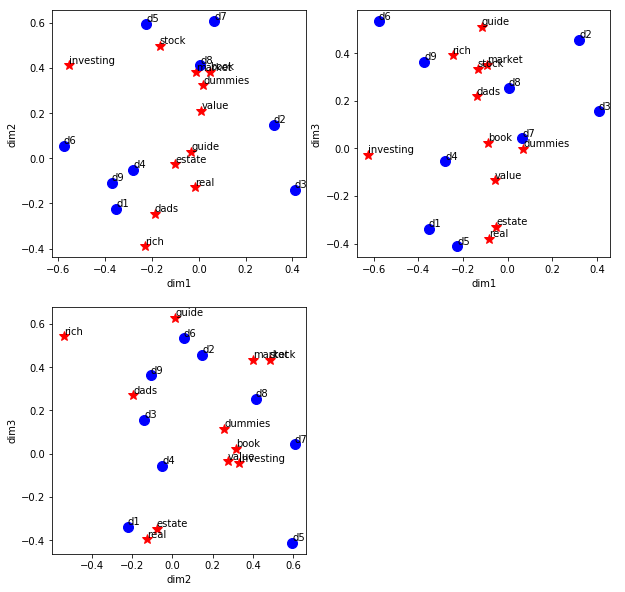

In [11]:
from scipy.special import binom

def plot_terms_docs(x_index, y_index, U, VT, df, ax):
    def get_jitter():
        return np.random.choice(np.linspace(0.05, 0.2, 10), 1)
    
    for i in range(len(df.index)):
        term = df.index[i]
        x = U[i][x_index] + get_jitter()
        y = U[i][y_index] + get_jitter()

        ax.plot(x, y, color='red', marker='*', markersize=10.0)
        ax.annotate(term, xy=(x, y), textcoords='data', horizontalalignment='left', verticalalignment='bottom')

    for i in range(VT.shape[1]):
        doc = 'd{}'.format(i + 1)
        x = VT[i][x_index]
        y = VT[i][y_index]

        ax.plot(x, y, color='blue', marker='o', markersize=10.0)
        ax.annotate(doc, xy=(x, y), textcoords='data', horizontalalignment='left', verticalalignment='bottom')
        
n = U_k.shape[1]
k = 2
num_plots = int(binom(n, k))
if num_plots % k != 0:
    num_plots = num_plots + 1
num_plots = num_plots / k
print('n = {}, k = {}, num_plots = {}'.format(n, k, num_plots))

fig, axes = plt.subplots(k, num_plots, sharex=False, sharey=False, figsize=(10, 10))
axes[-1, -1].axis('off')
axes = axes.ravel()
ax_counter = 0

for i in range(n):
    for j in range(n):
        if j > i:
            ax = axes[ax_counter]
            plot_terms_docs(i, j, U_k, VT, df, ax)
            ax.set_xlabel('dim{}'.format(i + 1))
            ax.set_ylabel('dim{}'.format(j + 1))

            ax_counter += 1

In [12]:
q.transpose().dot(U_k).dot(S_k)

array([[-0.35383506,  0.32093722,  0.40910955]])

In [13]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarity(q.transpose().dot(U_k).dot(S_k), V_k)

array([[ 1.        ,  0.36294035,  0.89084012,  0.25158578,  0.14171761,
         0.3660941 , -0.37487063,  0.76046024, -0.28002976]])

# References

* [Latent Semantic Indexing (LSI) An Example](http://www1.se.cuhk.edu.hk/~seem5680/lecture/LSI-Eg.pdf)
* [Latent Semantic Analysis (LSA) Tutorial](https://technowiki.wordpress.com/2011/08/27/latent-semantic-analysis-lsa-tutorial/)
* [pyLDAvis](http://nbviewer.jupyter.org/github/bmabey/pyLDAvis/blob/master/notebooks/pyLDAvis_overview.ipynb)
* [Using Gensim for LDA](http://christop.club/2014/05/06/using-gensim-for-lda/)
* [LSA / PLSA / LDA](https://cs.stanford.edu/~ppasupat/a9online/1140.html)
* [Cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity)
* [Scikit-Learn Cosine Similarity](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html)